In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random as rand
import numpy as np
import math
from tqdm.notebook import trange
from collections import defaultdict

In [2]:
def sigma(itr, f):
    return sum([f(i) for i in itr])
def mean(itr):
    return sum(itr)/len(itr)
def argmax(itr, f):
    return max(itr, key=f)

In [3]:
def table(array):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')
    t = plt.table(cellText=array, colWidths=[0.03] * len(array), loc = "center")
    t.auto_set_font_size(False)
    t.set_fontsize(24)
    t.scale(4, 4)

In [4]:
class Env:
    def A(self, s):
        return [i for i in range(9) if s[i] == 0] if s != "term" else [None]

    def init(self):
        return tuple(0 for _ in range(9))
    
    def step(self, s, a):
        A, checkWin = self.A, self.checkWin
        sn = tuple(s[i] if i != a else 1 for i in range(9))
        if checkWin(sn): return "term", 1
        #check draw
        if 0 not in sn: return "term", 0
        #opponent's turn
        a = rand.choice(A(sn))
        sn = tuple(sn[i] if i != a else -1 for i in range(9))
        if checkWin(sn): return "term", -1
        return sn, 0
    
    def checkWin(self, s):
        def checkLine(l):
            line = set(l)
            return len(line) == 1 if 0 not in line else False
        rows = any(checkLine(s[i*3:i*3+3]) for i in range(3))
        cols = any(checkLine((s[i], s[i+3], s[i+6])) for i in range(3))
        diag = checkLine((s[0], s[4], s[8])) or checkLine((s[2], s[4], s[6]))
        return rows or cols or diag

In [5]:
class MC:
    def __init__(self, env, Q=0, epsilon=0.01, alpha=0.01, gamma=1):
        self.env = env
        self.Q = defaultdict(lambda: Q)
        self.Q[("term", None)] = 0
        self.As = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
    
    def step(self):
        A, Q, As, pi, alpha, gamma = self.env.A, self.Q, self.As, self.pi, self.alpha, self.gamma
        init, step = self.env.init, self.env.step
        St = init()
        ep = []
        while St != "term":
            At = pi(St)
            St1, Rt1 = step(St, At)
            ep.append((St, At, Rt1))
            St = St1
        result = Rt1
        G = 0
        for t in reversed(range(len(ep))):
            St, At, Rt1 = ep[t]
            G = gamma*G + Rt1
            if (St, At) not in ep[:t]:
                Q[(St, At)] = Q[(St, At)] + alpha*(G - Q[(St, At)])
                As[St] = argmax(A(St), lambda a: Q[(St, a)])
        return result
    
    def pi(self, s):
        A, Q, As, epsilon = self.env.A, self.Q, self.As, self.epsilon
        As.setdefault(s, rand.choice(A(s)))
        greedy = rand.choices([True, False], [1-epsilon, epsilon])[0]
        return As[s] if greedy else rand.choice(A(s))

In [6]:
def MCTrial(K, N, *params):
    env = Env()
    mcs = [MC(env, *params) for _ in range(N)]
    X = []
    Y1 = []
    Y2 = []
    Y3 = []
    for k in trange(K):
        wins = 0
        losses = 0
        draws = 0
        for mc in mcs:
            result = mc.step()
            if result == 1:
                wins += 1
            elif result == 0:
                draws += 1
            else:
                losses += 1 
        X.append(k+1)
        Y1.append(wins/N)
        Y2.append(draws/N)
        Y3.append(losses/N)
        
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel("Episodes", fontsize=16)
    ax.plot(X, Y1, label = "Winrate")
    ax.plot(X, Y2, label = "Drawrate")
    ax.plot(X, Y3, label = "Lossrate")
    plt.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=16)
    ax.set_ylim(top=1, bottom=0)
    ax.set_xlim(left=0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    plt.show()
    return mcs, (X, Y1, Y2, Y3)

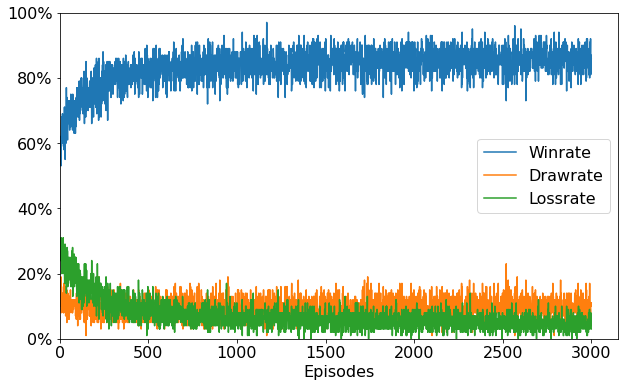

In [7]:
mcs, axes = MCTrial(3000, 100, 0)

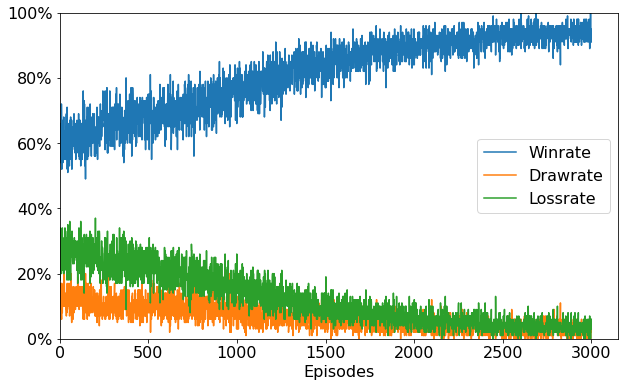

In [8]:
mcs, axes = MCTrial(3000, 100, 1)

In [9]:
X, Y1, Y2, Y3 = axes
Y1[-1], Y2[-1], Y3[-1]

(0.91, 0.03, 0.06)

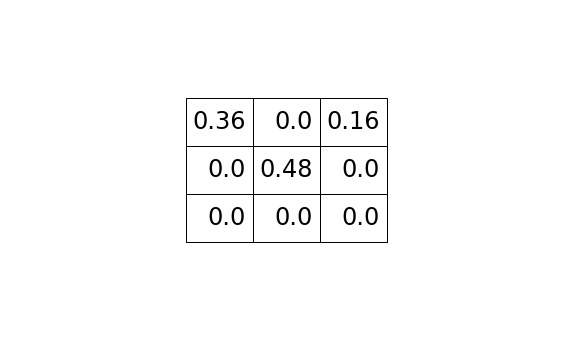

In [11]:
arr = np.zeros([3, 3])
for mc in mcs:
    i = mc.As[Env().init()]
    arr[i//3, i%3] += 1
table(arr/100)

In [18]:
class Sarsa0:
    def __init__(self, env, Q=0, epsilon=0.01, alpha=0.01, gamma=1):
        self.env = env
        self.Q = defaultdict(lambda: Q)
        self.Q[("term", None)] = 0
        self.As = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
    
    def step(self):
        A, Q, As, pi, alpha, gamma = self.env.A, self.Q, self.As, self.pi, self.alpha, self.gamma
        init, step = self.env.init, self.env.step
        St = init()
        At = pi(St)
        while St != "term":
            St1, R = step(St, At)
            At1 = pi(St1)
            Q[(St, At)] = Q[(St, At)] + alpha*(R + gamma*Q[(St1, At1)] - Q[(St, At)])
            As[St] = argmax(A(St), lambda a: Q[(St, a)])
            St, At = St1, At1
        return R
    
    def pi(self, s):
        A, Q, As, epsilon = self.env.A, self.Q, self.As, self.epsilon
        As.setdefault(s, rand.choice(A(s)))
        greedy = rand.choices([True, False], [1-epsilon, epsilon])[0]
        return As[s] if greedy else rand.choice(A(s))

In [19]:
def Sarsa0Trial(K, N, *params):
    env = Env()
    s0s = [Sarsa0(env, *params) for _ in range(N)]
    X = []
    Y1 = []
    Y2 = []
    Y3 = []
    for k in trange(K):
        wins = 0
        losses = 0
        draws = 0
        for s0 in s0s:
            result = s0.step()
            if result == 1:
                wins += 1
            elif result == 0:
                draws += 1
            else:
                losses += 1 
        X.append(k+1)
        Y1.append(wins/N)
        Y2.append(draws/N)
        Y3.append(losses/N)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel("Episodes", fontsize=16)
    ax.plot(X, Y1, label = "Winrate")
    ax.plot(X, Y2, label = "Drawrate")
    ax.plot(X, Y3, label = "Lossrate")
    plt.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=16)
    ax.set_ylim(top=1, bottom=0)
    ax.set_xlim(left=0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    plt.show()
    return s0s, (X, Y1, Y2, Y3)

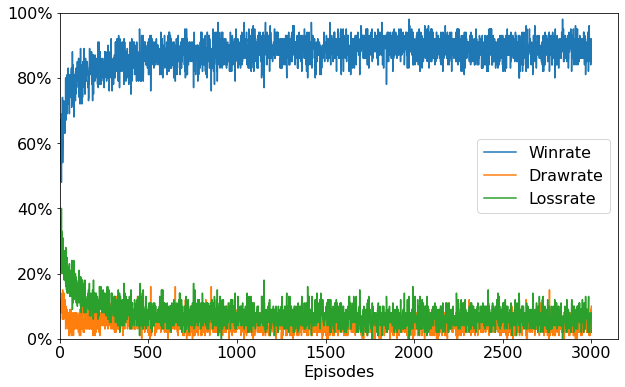

In [20]:
s0s, axes = Sarsa0Trial(3000, 100, 1)